#  Electricity Demand Prediction Using Weather Data
### Data Processing, Analysis, and Regression Modeling
This notebook loads, cleans, analyzes, and models electricity demand based on weather data.


## Import Libraries

In [14]:
import os
import glob
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore

## Load and Merge Data

In [15]:
def load_data(csv_dir, json_dir):
    """
    Loads and merges CSV and JSON files from separate directories.
    Extracts relevant data, ensures column consistency, and returns a merged DataFrame.
    """
    dataframes = []
    
    # Load CSV files
    csv_files = glob.glob(os.path.join(csv_dir, '**/*.csv'), recursive=True)
    for file in csv_files:
        df = pd.read_csv(file, encoding='utf-8', low_memory=False)
        df.rename(columns={'date': 'timestamp'}, inplace=True)
        dataframes.append(df)
    
    # Load JSON files
    json_files = glob.glob(os.path.join(json_dir, '**/*.json'), recursive=True)
    for file in json_files:
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        df = pd.DataFrame(data.get('response', {}).get("data", []))  # Extract response object safely
        df.rename(columns={'period': 'timestamp','value': 'electricity_demand'}, inplace=True)
        dataframes.append(df)
    
    # Merge all data
    if dataframes:
        merged_df = pd.concat(dataframes, ignore_index=True)
        merged_df.sort_values(by='timestamp', inplace=True)
        return merged_df
    else:
        return pd.DataFrame()



**Load Data**

In [16]:
directory_csv = 'E:/Data science/raw/weather_raw_data'
directory_json = 'E:/Data science/raw/electricity_raw_data'
df = load_data(directory_csv, directory_json)

if df.empty:
    raise ValueError("No data loaded. Please check the file paths and content.")


## Data Preprocessing

**Convert Column Names**

In [17]:
# Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Ensure numerical columns are correctly cast
df['electricity_demand'] = pd.to_numeric(df['electricity_demand'], errors='coerce')



**Detect and Remove Duplicate Rows**

In [18]:
duplicate_count = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")
df = df.drop_duplicates()
print("Duplicates removed.")

duplicate_count_after = df.duplicated().sum()
print(f"Remaining duplicate rows: {duplicate_count_after}")

Total duplicate rows: 378880
Duplicates removed.
Remaining duplicate rows: 0


## Feature Engineering

**DataType Conversion**

In [19]:
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek

**Handling Missing Data**

In [20]:

def analyze_missing_data(df):
    """Analyzes and handles missing data"""
    missing_percentage = df.isnull().mean() * 100
    print('Missing Data Percentage:', missing_percentage)
    df.ffill(inplace=True)  # Updated to avoid FutureWarning
    return df

df = analyze_missing_data(df)

# Drop rows with excessive missing values
df.dropna(subset=['electricity_demand'], inplace=True)

Missing Data Percentage: timestamp             46.275772
temperature_2m        45.318397
subba                 54.832559
subba-name            54.832559
parent                54.832559
parent-name           54.832559
electricity_demand    54.832559
value-units           54.832559
hour                  46.275772
day                   46.275772
month                 46.275772
day_of_week           46.275772
dtype: float64


## Outlier Detection

In [21]:
def detect_outliers_iqr(data, column):
    if column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return pd.DataFrame()

outliers = detect_outliers_iqr(df, "electricity_demand")
df = df[~df.index.isin(outliers.index)]  # Remove outliers

# Apply Z-score method
df = df[(np.abs(zscore(df["electricity_demand"].dropna())) < 3)]

## Data Visualization

**Correlation Heatmap**

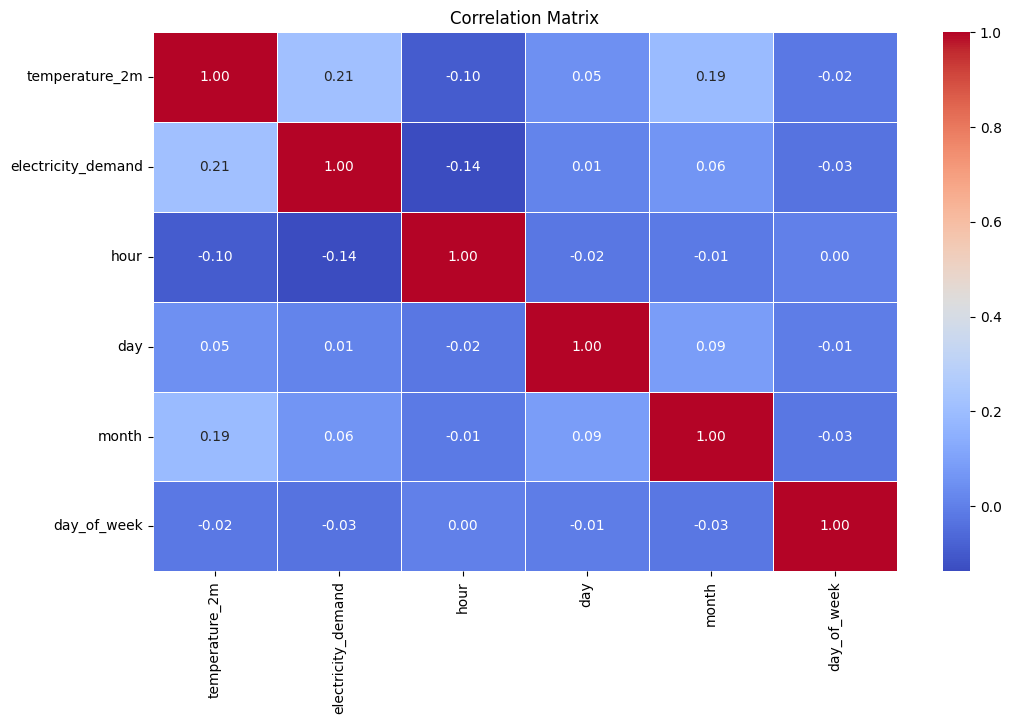

In [22]:
if not df.empty:
    numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
    plt.figure(figsize=(12, 7))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

**Time Series Decomposition**

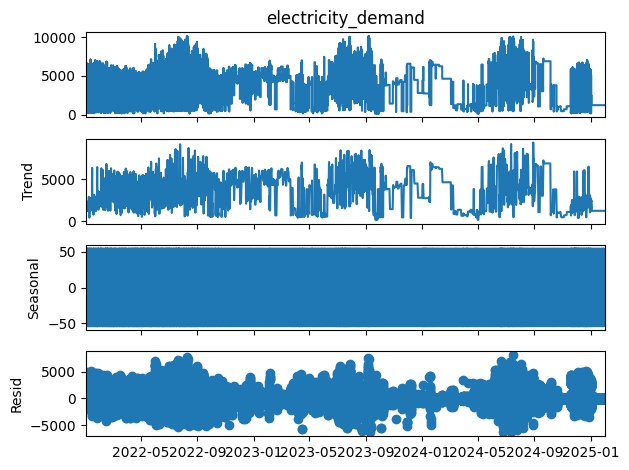

In [23]:

try:
    if len(df) >= 48:
        result = seasonal_decompose(df.set_index('timestamp')['electricity_demand'], model='additive', period=24)
        result.plot()
        plt.show()
    else:
        print("Insufficient data for time series decomposition.")
except Exception as e:
    print("Time series decomposition error:", e)

## Regression Modeling

**Linear Regression and Random Forest**

In [24]:
X = df[['hour', 'day', 'month', 'day_of_week']]
y = df['electricity_demand']

if X.empty or y.empty:
    raise ValueError("Insufficient data for regression modeling.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Linear Regression - MSE: {mse_lr}, RMSE: {rmse_lr}, R²: {r2_lr}')
print(f'Random Forest - MSE: {mse_rf}, RMSE: {rmse_rf}, R²: {r2_rf}')

Linear Regression - MSE: 5160393.487870806, RMSE: 2271.649948357098, R²: 0.019491482800036763
Random Forest - MSE: 1876501.0793918248, RMSE: 1369.8544008002548, R²: 0.6434525205871913


**Residual Analysis**

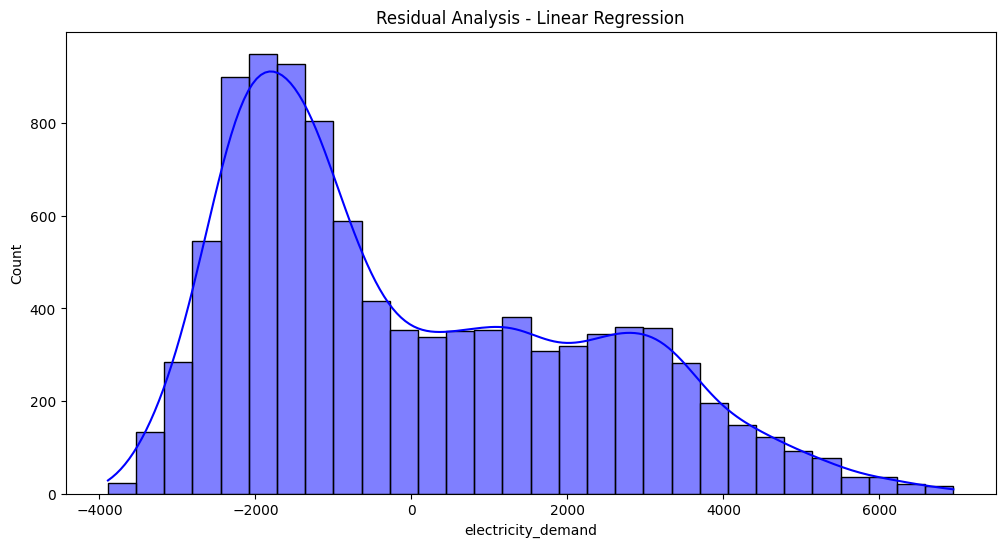

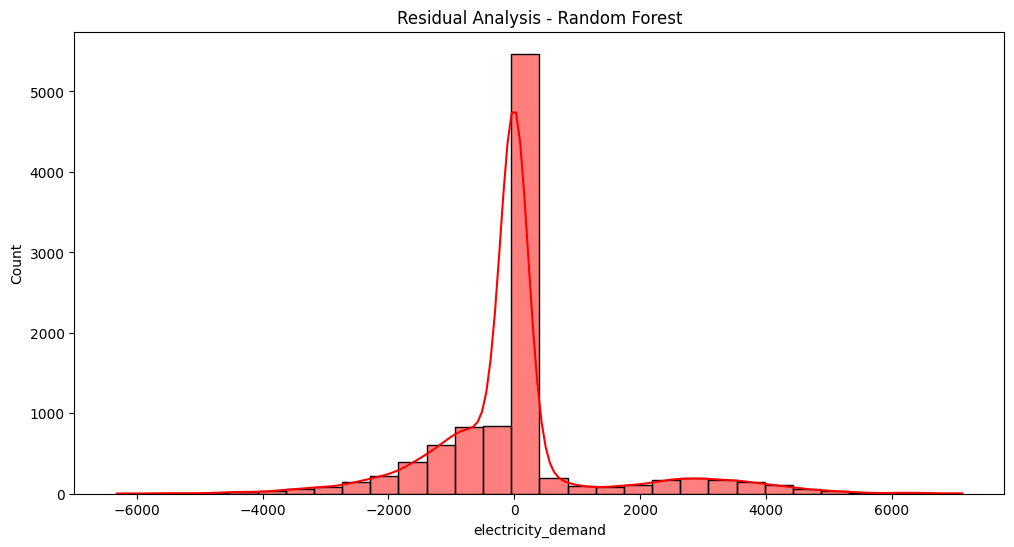

In [25]:
plt.figure(figsize=(12,6))
sns.histplot(y_test - y_pred_lr, bins=30, kde=True, color='blue')
plt.title('Residual Analysis - Linear Regression')
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(y_test - y_pred_rf, bins=30, kde=True, color='red')
plt.title('Residual Analysis - Random Forest')
plt.show()


**Save Processed Data**

In [26]:
df.to_csv('E:/Data science/merged_and_processed_data.csv', index=False)
print("Merged and processed data saved successfully.")

Merged and processed data saved successfully.
